In [52]:
%reset
from numba import jit
import numpy as np
from matplotlib import pylab as plt
from matplotlib.patches import Ellipse
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# setup: 
try a basic algorithm using a for-loop

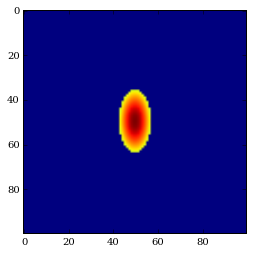

In [53]:
X = np.linspace(-10,10,100)
Y = np.linspace(-10,10,100)
XX,YY = np.meshgrid(X,Y)
pixels = np.exp(-(XX**2)/4.0) * np.exp(-(YY**2)/16.0)
pixels[pixels<0.6] = 0
plt.imshow(pixels)
numpix = len(X) * len(Y)

In [54]:
print( len(XX.ravel()) )

10000


In [55]:
def algo(pixels,X,Y, numpix):
    sum_x = 0
    sum_y = 0
    for ii in range(numpix):
        sum_x += X[ii] * pixels[ii]
        sum_y += Y[ii] * pixels[ii]
        
    return sum_x,sum_y

fastalgo = jit(algo) # apply the decorator
fastalgo(pixels.ravel(),XX.ravel(),YY.ravel(), numpix)

fastalgo2 = jit(algo, nopython=True) # apply the decorator
fastalgo2(pixels.ravel(),XX.ravel(),YY.ravel(), numpix)

fastalgo3 = jit(algo, nopython=True,nogil=True) # apply the decorator
fastalgo3(pixels.ravel(),XX.ravel(),YY.ravel(), numpix)


(-1.5376588891058418e-14, -8.881784197001252e-16)

In [56]:
%timeit algo(pixels.ravel(),XX.ravel(),YY.ravel(),numpix)
%timeit fastalgo(pixels.ravel(),XX.ravel(),YY.ravel(),numpix)
%timeit fastalgo2(pixels.ravel(),XX.ravel(),YY.ravel(),numpix)
%timeit fastalgo3(pixels.ravel(),XX.ravel(),YY.ravel(),numpix)

100 loops, best of 3: 6.79 ms per loop
100000 loops, best of 3: 10.6 µs per loop
100000 loops, best of 3: 10.5 µs per loop
100000 loops, best of 3: 10.7 µs per loop


In [57]:
fastalgo.inspect_types()

algo (array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), int64)
--------------------------------------------------------------------------------
# File: <ipython-input-55-508ba05415c7>
# --- LINE 1 --- 

def algo(pixels,X,Y, numpix):

    # --- LINE 2 --- 
    # label 0
    #   pixels = arg(0, name=pixels)  :: array(float64, 1d, C)
    #   X = arg(1, name=X)  :: array(float64, 1d, C)
    #   Y = arg(2, name=Y)  :: array(float64, 1d, C)
    #   numpix = arg(3, name=numpix)  :: int64
    #   $const0.1 = const(int, 0)  :: int32
    #   sum_x = $const0.1  :: float64
    #   del $const0.1

    sum_x = 0

    # --- LINE 3 --- 
    #   $const0.2 = const(int, 0)  :: int32
    #   sum_y = $const0.2  :: float64
    #   del $const0.2

    sum_y = 0

    # --- LINE 4 --- 
    #   jump 12
    # label 12
    #   $12.1 = global(range: <class 'range'>)  :: range
    #   $12.3 = call $12.1(numpix, )  :: (int64,) -> range_state64
    #   del numpix
    #   del $12.1
    #   $12.4 = get

try a NumPy-only version and see what Numba does to it:

In [61]:
def npalgo(pixels,X,Y,numpix=10000):    
    return np.sum(pixels*X),np.sum(pixels*Y)

fastnpalgo = jit(npalgo)
fastnpalgo(pixels,X,Y)

(-1.7486012637846216e-14, -1.7486012637846216e-14)

In [62]:
%timeit npalgo(pixels,X,Y)
%timeit fastnpalgo(pixels,X,Y)

The slowest run took 5.29 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 39.4 µs per loop
10000 loops, best of 3: 39.1 µs per loop


#conclusion:
so the conclusion is that writing functions that use _NumPy_ properly gives you very fast speed. If you don't use NumPy to avoid all loops, you should use Numba to optimize the function, and you get similar results (sometimes a factor of 10 faster!)

Let's try soe other Numba features:
## turn a func into a ufunc:

In [63]:
import numba
from numba import int32,float32,float64,int64
import numpy as np

@numba.vectorize([int32(int32, int32),
            int64(int64, int64),
            float32(float32, float32),
            float64(float64, float64)])
def plork(a,b):
    return a**2 + b**2

In [64]:
plork( np.arange(10), 10.2 )

array([ 104.04,  105.04,  108.04,  113.04,  120.04,  129.04,  140.04,
        153.04,  168.04,  185.04])

In [65]:
plork( np.linspace(-1,1,10),np.linspace(-5,5,10))

array([ 26.        ,  15.72839506,   8.02469136,   2.88888889,
         0.32098765,   0.32098765,   2.88888889,   8.02469136,
        15.72839506,  26.        ])

In [77]:
A = np.linspace(-1,1,100)*0.5
A.reshape(10,10)
plork.accumulate( A,axis=0)

array([ -5.00000000e-01,   4.90001020e-01,   4.70307101e-01,
         4.41804013e-01,   4.06419232e-01,   3.67222302e-01,
         3.27919253e-01,   2.91823456e-01,   2.60882794e-01,
         2.35415204e-01,   2.14613258e-01,   1.97293418e-01,
         1.82404950e-01,   1.69201573e-01,   1.57212990e-01,
         1.46157614e-01,   1.35865670e-01,   1.26229096e-01,
         1.17173454e-01,   1.08643403e-01,   1.00595349e-01,
         9.29936207e-02,   8.58083073e-02,   7.90139176e-02,
         7.25884701e-02,   6.65128366e-02,   6.07702486e-02,
         5.53459157e-02,   5.02267251e-02,   4.54010016e-02,
         4.08583125e-02,   3.65893078e-02,   3.25855890e-02,
         2.88395984e-02,   2.53445273e-02,   2.20942377e-02,
         1.90831967e-02,   1.63064192e-02,   1.37594204e-02,
         1.14381738e-02,   9.33907588e-03,   7.45891510e-03,
         5.79484570e-03,   4.34436485e-03,   3.10529326e-03,
         2.07575855e-03,   1.25418124e-03,   6.39263002e-04,
         2.29977069e-04,

In [78]:
def hillas_parameters(x, y, s):
    """Compute Hillas parameters for a given shower image.

    Reference: Appendix of the Whipple Crab paper Weekes et al. (1998) 
    http://adsabs.harvard.edu/abs/1989ApJ...342..379W
    (corrected for some obvious typos) 

    Parameters
    ----------
    x : array_like
        Pixel x-coordinate
    y : array_like
        Pixel y-coordinate
    s : array_like
        Pixel value

    Returns
    -------
    hillas_parameters : dict
        Dictionary of Hillas parameters
    """
    x = np.asanyarray(x, dtype=np.float64)
    y = np.asanyarray(y, dtype=np.float64)
    s = np.asanyarray(s, dtype=np.float64)
    assert x.shape == s.shape
    assert y.shape == s.shape

    # Compute image moments
    # note these may be pre-computed for even more speed, rather than computed at each call
    _s = np.sum(s)
    m_x = np.sum(s * x) / _s
    m_y = np.sum(s * y) / _s
    m_xx = np.sum(s * x**2) / _s  # note: typo in paper
    m_yy = np.sum(s * y**2) / _s
    m_xy = np.sum(s * x * y) / _s  # note: typo in paper

    # Compute major axis line representation y = a * x + b
    S_xx = m_xx - m_x * m_x
    S_yy = m_yy - m_y * m_y
    S_xy = m_xy - m_x * m_y
    d = S_yy - S_xx
    temp = d**2 + 4 * S_xy * S_xy
    a = (d + np.sqrt(temp)) / (2 * S_xy)
    b = m_y - a * m_x

    # Compute Hillas parameters
    width_2 = (S_yy + a**2 * S_xx - 2 * a * S_xy) / (1 + a**2)
    width = np.sqrt(width_2)
    length_2 = (S_xx + a**2 * S_yy + 2 * a * S_xy) / (1 + a**2)
    length = np.sqrt(length_2)
    miss = np.abs(b / (1 + a**2))
    r = np.sqrt(m_x**2 + m_y**2)

    # Compute azwidth by transforming to (p, q) coordinates
    sin_theta = m_y / r
    cos_theta = m_x / r
    q = (m_x - x) * sin_theta + (y - m_y) * cos_theta
    m_q = np.sum(s * q) / _s
    m_qq = np.sum(s * q**2) / _s
    azwidth_2 = m_qq - m_q**2
    azwidth = np.sqrt(azwidth_2)

    # Return relevant parameters in a dict
    return dict(x= m_x, y= m_y, 
                a = a, b = b,
                width=width,
                length=length,
                miss = miss,
                r = r,
                azwidth=azwidth)


In [83]:
%timeit -n 10000  hillas_parameters( XX,YY,pixels )

# now on only the non-zero pixels:
mask=pixels>1e-10
%timeit hillas_parameters( XX[mask],YY[mask],pixels[mask])

10000 loops, best of 3: 193 µs per loop
10000 loops, best of 3: 65.8 µs per loop


In [81]:
numba_hillas_parameters = jit(hillas_parameters)
numba_hillas_parameters( XX,YY,pixels )
%timeit numba_hillas_parameters( XX,YY,pixels )

1000 loops, best of 3: 214 µs per loop


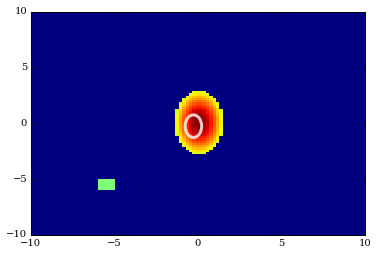

In [84]:

pixels[20:25,20:25] = 0.5

plt.pcolormesh(X,Y,pixels)
params = hillas_parameters(XX,YY,pixels)
hillas_ellipse = Ellipse( xy=(params['x'],params['y']), 
                          width=params['width'], 
                          height=params['length'])
hillas_ellipse.set_edgecolor('white') 
hillas_ellipse.set_facecolor('none') 
hillas_ellipse.set_linewidth(3)
hillas_ellipse.set_alpha(0.8)


ax = plt.gca()
ax.add_artist(hillas_ellipse)
plt.show()
